In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
treino_dataset = r'Data\chest_xray\test'
teste_dataset = r'Data\chest_xray\train'
valida_dataset = r'Data\chest_xray\val'

In [ ]:
# Pré-processamento
pastas = ['NORMAL', 'PNEUMONIA']
tamanho_imagem = 150
def carregar_imagens(dataset):
    X = []
    y = []
    for pasta in pastas:
        caminho_pasta = os.path.join(dataset, pasta)
        indice = pastas.index(pasta)
        
        if not os.path.isdir(caminho_pasta):
            print(f"Pasta {caminho_pasta} não encontrada.")
            continue
        
        for img in os.listdir(caminho_pasta):
            if not img.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            caminho_imagem = os.path.join(caminho_pasta, img)
            imagem = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
            if imagem is None:
                print(f"Falha ao carregar {caminho_imagem}")
                continue

            imagem_redimensionada = cv2.resize(imagem, (tamanho_imagem, tamanho_imagem))
            X.append(imagem_redimensionada.flatten())
            y.append(indice)
    
    return np.array(X), np.array(y)

X_treino, y_treino = carregar_imagens(treino_dataset)
X_teste, y_teste = carregar_imagens(teste_dataset)

In [5]:
# Normalização
scaler = StandardScaler()
X_treino_norm = scaler.fit_transform(X_treino)
X_teste_norm = scaler.transform(X_teste)

In [107]:
# PCA 
pca = PCA(n_components=0.85)  # 85% de variância
X_treino_pca = pca.fit_transform(X_treino_norm)
X_teste_pca = pca.transform(X_teste_norm)  

print(f"Número de componentes selecionados: {pca.n_components_}")

Número de componentes selecionados: 71


In [109]:
# Regressão logística
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
model.fit(X_treino_pca, y_treino)

# Avaliação
y_pred = model.predict(X_teste_pca)
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      1341
           1       0.95      0.87      0.91      3875

    accuracy                           0.87      5216
   macro avg       0.82      0.86      0.84      5216
weighted avg       0.88      0.87      0.87      5216



In [ ]:
# Simula PCA com todos os componentes
pca_full = PCA().fit(X_treino_norm) 

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), 'bo-')
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.axvline(x=pca.n_components_, color='g', linestyle='--', label="PCA usado (85% de variância)")
plt.axvline(x=241, color='y', linestyle='--', label="PCA usado (95% de variância)")
plt.title("Gráfico da Variância Explicada pelo PCA")
plt.legend()
plt.grid()
plt.show()

              precision    recall  f1-score   support

      NORMAL       0.88      0.88      0.88         8
   PNEUMONIA       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16



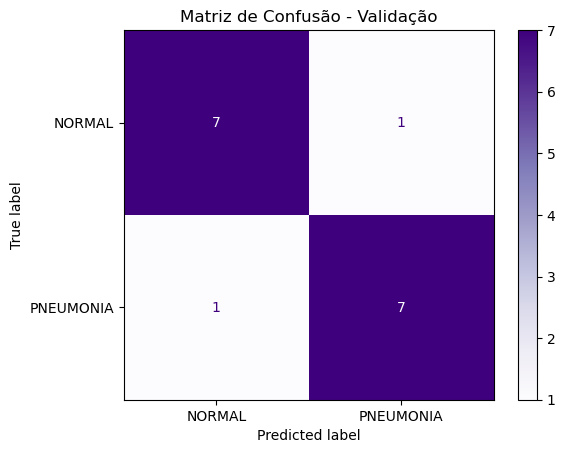

In [ ]:
# Validação
X_val, y_val = carregar_imagens(valida_dataset)
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)

y_val_pred = model.predict(X_val_pca)

print(classification_report(y_val, y_val_pred, target_names=pastas))

matriz_val = ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, display_labels=pastas, cmap='Purples')
matriz_val.ax_.set_title('Matriz de Confusão - Validação')
plt.show()


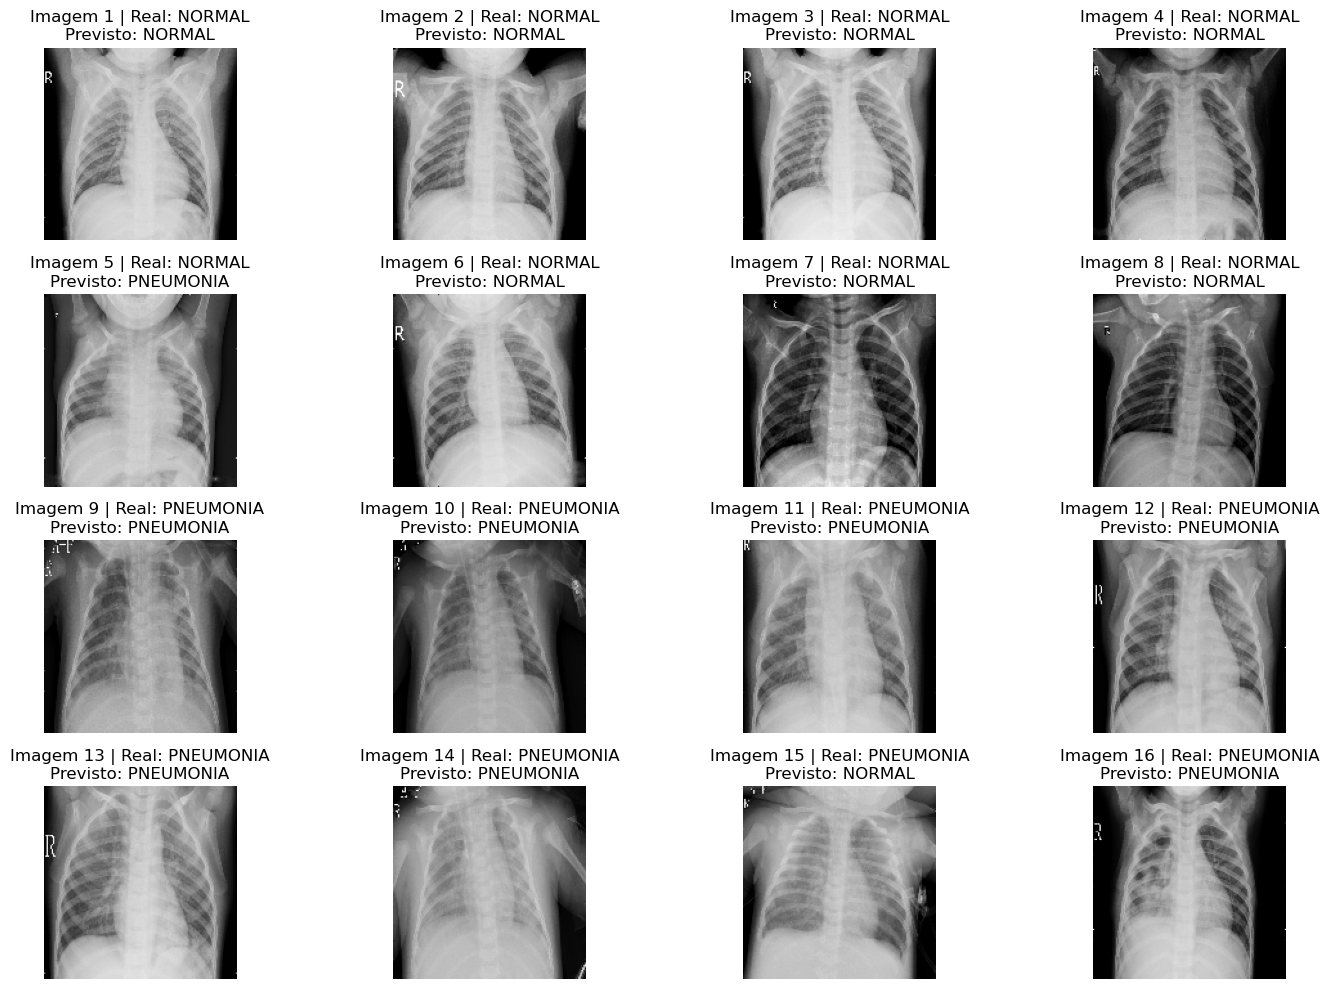

In [120]:
n_imagens = 16
fig, eixos = plt.subplots(4, 4, figsize=(15, 10))  

for i, ex in enumerate(eixos.flat):
    if i >= len(X_val):
        break

    imagem_2d = X_val[i].reshape(tamanho_imagem, tamanho_imagem)

    ex.imshow(imagem_2d, cmap='gray')
    ex.axis('off')

    ex.set_title(f"Imagem {i+1} | Real: {pastas[y_val[i]]}\nPrevisto: {pastas[y_val_pred[i]]}")

plt.tight_layout()
plt.show()
